In [2]:
import requests
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import sleep
from tqdm import tqdm

In [5]:
# --- Black-Scholes Greeks ---
def bs_d1(S, K, r, q, sigma, tau):
    return (np.log(S/K) + (r - q + 0.5*sigma**2)*tau) / (sigma * np.sqrt(tau))


def bs_d2(d1, sigma, tau):
    return d1 - sigma * np.sqrt(tau)


def bs_price_delta_gamma_vega_theta(S, K, r, q, sigma, tau, option_type='call'):
# Returns dict with price, delta, gamma, vega, theta (theta per year)
    if tau <= 0:
# expiry
        if option_type == 'call':
            price = max(S-K, 0.0)
            delta = 1.0 if S > K else 0.0
        else:
            price = max(K-S, 0.0)
            delta = -1.0 if S < K else 0.0
        return {'price': price, 'delta': delta, 'gamma': 0.0, 'vega': 0.0, 'theta': 0.0}


    d1 = bs_d1(S, K, r, q, sigma, tau)
    d2 = bs_d2(d1, sigma, tau)
    pdf_d1 = norm.pdf(d1)
    cdf_d1 = norm.cdf(d1)
    cdf_d2 = norm.cdf(d2)
    discount_q = np.exp(-q * tau)
    discount_r = np.exp(-r * tau)


    if option_type == 'call':
        price = S * discount_q * cdf_d1 - K * discount_r * cdf_d2
        delta = discount_q * cdf_d1
    else:
        price = K * discount_r * norm.cdf(-d2) - S * discount_q * norm.cdf(-d1)
        delta = -discount_q * norm.cdf(-d1)


    gamma = discount_q * pdf_d1 / (S * sigma * np.sqrt(tau))
    vega = S * discount_q * pdf_d1 * np.sqrt(tau)
# Theta (per year) approximate (European) - using standard BS theta formula
    term1 = - (S * discount_q * pdf_d1 * sigma) / (2 * np.sqrt(tau))
    if option_type == 'call':
        term2 = q * S * discount_q * cdf_d1
        term3 = - r * K * discount_r * cdf_d2
        theta = term1 - term2 + term3
    else:
        term2 = q * S * discount_q * norm.cdf(-d1)
        term3 = - r * K * discount_r * norm.cdf(-d2)
        theta = term1 + term2 - term3


    return {'price': price, 'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta}

In [6]:
NSE_OPTION_CHAIN_URL = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"
NSE_HOMEPAGE = "https://www.nseindia.com"

In [7]:
def fetch_nse_option_chain(retries=3, sleep_sec=1.0):
    s = requests.Session()
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
        '(KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept': 'application/json, text/plain, */*'
    }
    for attempt in range(retries):
        try:
# initial GET to obtain cookies & headers expected by NSE
            s.get(NSE_HOMEPAGE, headers=headers, timeout=10)
            resp = s.get(NSE_OPTION_CHAIN_URL, headers=headers, timeout=10)
            if resp.status_code == 200:
                return resp.json()
            else:
            # wait and retry
                sleep(sleep_sec)
        except Exception as e:
            sleep(sleep_sec)
    raise RuntimeError('Failed to fetch NSE option chain. NSE may block automated requests; consider using saved CSVs or a broker API.')

In [8]:
def option_chain_json_to_df(json_obj):
    records = []
# 'filtered' or 'records' structure in response; defensive parsing
    data = json_obj.get('records') or json_obj
    underlying = data.get('underlyingValue')
    expiry_dates = data.get('expiryDates', [])
    timestamp = data.get('timestamp') or datetime.utcnow().isoformat()


# 'data' key contains per-strike elements under 'records'
    rows = data.get('data') or []
    for r in rows:
        strike = r.get('strikePrice')
        ce = r.get('CE')
        pe = r.get('PE')
        row_common = {
            'strike': strike,
            'underlying': underlying,
            'timestamp': timestamp
        }
        if ce:
            records.append({**row_common,
                        'option_type': 'CE',
                        'ltp': ce.get('lastPrice'),
                        'bid': ce.get('bidprice'),
                        'ask': ce.get('askPrice'),
                        'iv': ce.get('impliedVolatility'),
                        'oi': ce.get('openInterest'),
                        'volume': ce.get('totalTradedVolume')})
        if pe:
            records.append({**row_common,
                        'option_type': 'PE',
                        'ltp': pe.get('lastPrice'),
                        'bid': pe.get('bidprice'),
                        'ask': pe.get('askPrice'),
                        'iv': pe.get('impliedVolatility'),
                        'oi': pe.get('openInterest'),
                        'volume': pe.get('totalTradedVolume')})
    df = pd.DataFrame(records)
# drop rows with missing strike/iv
    df = df.dropna(subset=['strike'])
    return df

In [10]:
def load_historical_csvs(folder_path, pattern='*.csv'):
    import glob
    files = sorted(glob.glob(folder_path + '/*.csv'))
    dfs = []
    for f in files:
        try:
            d = pd.read_csv(f)
            d['source_file'] = f
            dfs.append(d)
        except Exception as e:
            print('failed to read', f, e)
    if not dfs:
        raise RuntimeError('No CSVs loaded')
    return pd.concat(dfs, ignore_index=True)

In [11]:
def historical_annual_vol(price_series, window=30):
# price_series is pandas Series indexed by date
    returns = price_series.pct_change().dropna()
    daily_vol = returns.rolling(window).std().iloc[-1]
    annual_vol = daily_vol * np.sqrt(252)
    return annual_vol

In [12]:
# Expected 1-day move (absolute) using historical vol
# expected_move_abs = S * sigma_hist / sqrt(252)


def expected_one_day_move(S, sigma_annual):
    return S * sigma_annual / np.sqrt(252)


# Gamma capture approx for small move: 0.5 * Gamma * (deltaS)^2


def expected_gamma_gain_per_option(gamma, deltaS, lot_size=50):
# per option contract (not per lot), so we multiply by lot_size to get rupee P&L per lot
    return 0.5 * gamma * (deltaS**2) * lot_size


# Theta from BS function is per-year; convert to per-day by dividing by 252


def theta_per_day(theta_per_year):
    return theta_per_year / 252.0


# Transaction cost estimate per day (rough) - user to adjust
DEFAULT_TC_PER_LOT = 40.0 # rupees round-trip approx (example)

In [13]:
def analyze_snapshot(df_chain, historical_underlying_series=None, r=0.07, q=0.0, lot_size=50, tc_per_lot=DEFAULT_TC_PER_LOT):
# df_chain columns: ['strike','option_type','ltp','iv','underlying','timestamp']
    S = float(df_chain['underlying'].dropna().unique()[0])
# estimate historical vol if series provided
    if historical_underlying_series is not None:
        sigma_annual = historical_annual_vol(historical_underlying_series)
    else:
# fallback: use median IV of ATM options as proxy
        sigma_annual = df_chain.loc[df_chain['strike'].between(S*0.95, S*1.05), 'iv'].median() / 100.0
        if np.isnan(sigma_annual):
            sigma_annual = 0.20
    deltaS = expected_one_day_move(S, sigma_annual)


    rows = []
# compute days to expiry & convert iv percent to decimal
# If original JSON had expiry info per strikes we could use it; here we assume near-term expiry if not provided
# We'll assume a default of 7 days for demonstration unless expiry provided.
    default_days_to_expiry = 7
    for _, row in df_chain.iterrows():
        strike = float(row['strike'])
        opt_type = row['option_type']
        iv_pct = row['iv']
        if pd.isna(iv_pct) or iv_pct == 0:
            continue
        sigma = float(iv_pct)/100.0
# time to expiry in years (approx) - try to parse if timestamp has 'expiryDate' column
# User can enrich df_chain with explicit 'days_to_expiry' column for accuracy
        days_to_expiry = row.get('days_to_expiry', default_days_to_expiry)
        tau = max(days_to_expiry, 1) / 252.0
        greeks = bs_price_delta_gamma_vega_theta(S, strike, r, q, sigma, tau, option_type='call' if opt_type=='CE' else 'put')
        gamma = greeks['gamma']
        theta_yr = greeks['theta']
        theta_day = theta_per_day(theta_yr)
        gamma_gain = expected_gamma_gain_per_option(gamma, deltaS, lot_size=lot_size)
# net expected per-day (rough) = gamma_gain - (|theta_day|*lot_size) - tc_per_lot/expected_holding_days?
        theta_cost_per_day = abs(theta_day) * lot_size
        net_estimated = gamma_gain - theta_cost_per_day - (tc_per_lot/ max(days_to_expiry,1))
        rows.append({'strike': strike, 'option_type': opt_type, 'iv': sigma, 'gamma': gamma, 'theta_day_per_lot': theta_cost_per_day,'gamma_gain_per_lot': gamma_gain, 'net_estimated_per_day': net_estimated, 'days_to_expiry': days_to_expiry})
    out = pd.DataFrame(rows)
    out = out.sort_values(['net_estimated_per_day'], ascending=False).reset_index(drop=True)
    return out, S, deltaS

In [14]:
def plot_top_candidates(df_greeks, S, top_n=10):
    top = df_greeks.head(top_n)
    fig, ax = plt.subplots(figsize=(10,6))
    strikes = top['strike']
    ax.bar(strikes - (0.2* (S/1000)), top['gamma_gain_per_lot'], width=5, label='Gamma gain per lot (1-day approx)')
    ax.bar(strikes + (0.2*(S/1000)), top['theta_day_per_lot'], width=5, label='Theta cost per lot (per day)')
    ax.set_xlabel('Strike')
    ax.set_title('Top Long-Gamma Candidates (by net estimated 1-day)')
    ax.legend()
    plt.show()

In [15]:
def plot_gamma_vs_strike(df_greeks, S):
    fig, ax = plt.subplots(figsize=(12,6))
    df_plot = df_greeks.copy()
    df_plot['strike_diff'] = df_plot['strike'] - S
    ax.scatter(df_plot['strike_diff'], df_plot['gamma'], s=20)
    ax.set_xlabel('Strike - Spot')
    ax.set_ylabel('Gamma')
    ax.set_title('Gamma across strikes')
    plt.axvline(0, color='red', linestyle='--', label='ATM')
    plt.show()

Fetching live option chain from NSE...
Snapshot rows: 1360
Spot: 24741.0 expected 1-day move approx (Rs): 133.64
     strike option_type      iv     gamma  theta_day_per_lot  \
0   24900.0          PE  0.0794  0.001154         222.686808   
1   24850.0          PE  0.0787  0.001210         256.259997   
2   25100.0          PE  0.0860  0.000776          66.694032   
3   25000.0          PE  0.0835  0.000967         156.066034   
4   25150.0          PE  0.0886  0.000681          32.654644   
5   25050.0          PE  0.0855  0.000868         117.870205   
6   24950.0          PE  0.0831  0.001047         203.251651   
7   24800.0          PE  0.0788  0.001227         285.440697   
8   24750.0          PE  0.0792  0.001212         305.524469   
9   24700.0          PE  0.0800  0.001164         316.727641   
10  25200.0          PE  0.0840  0.000583          58.080558   
11  25150.0          PE  0.0972  0.000673         101.893273   
12  25300.0          PE  0.1027  0.000468          10.7

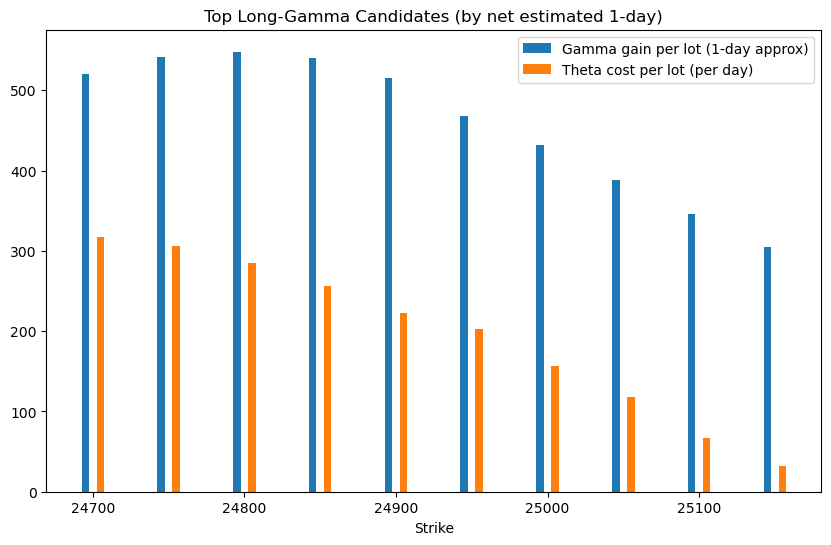

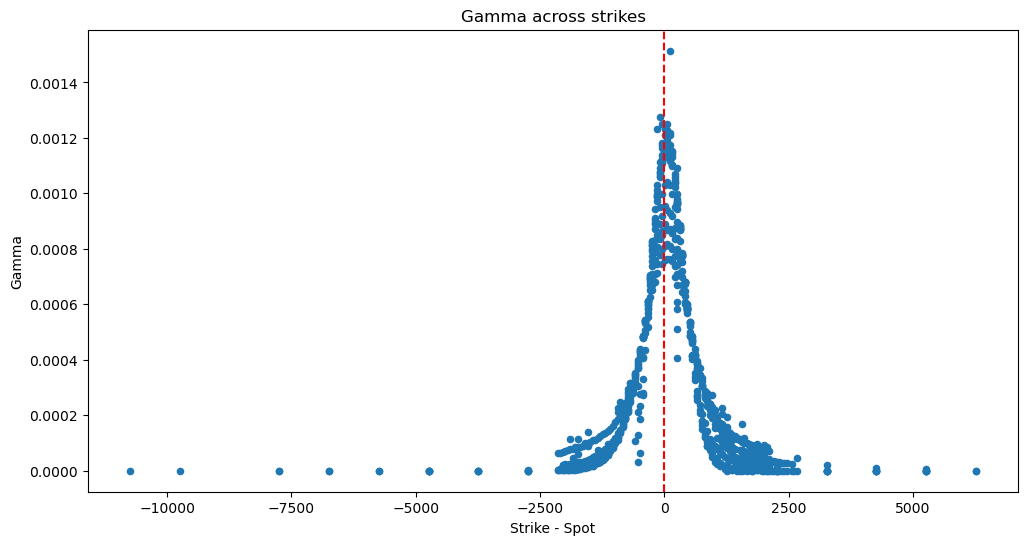

If NSE blocks automatic requests, use historical CSVs and load them with load_historical_csvs().


In [22]:
if __name__ == '__main__':
    print('Fetching live option chain from NSE...')
    try:
        raw = fetch_nse_option_chain()
        df_chain = option_chain_json_to_df(raw)
        print('Snapshot rows:', len(df_chain))
        # Optionally, enrich df_chain with days_to_expiry by mapping expiryDates in the JSON (omitted here)
        # quick analysis
        df_greeks, spot, deltaS = analyze_snapshot(df_chain)
        print('Spot:', spot, 'expected 1-day move approx (Rs):', round(deltaS,2))
        display = df_greeks.head(20)
        print(display)
        plot_top_candidates(df_greeks, spot)
        plot_gamma_vs_strike(df_greeks, spot)
    except Exception as e:
        print('Error:', e)
print('If NSE blocks automatic requests, use historical CSVs and load them with load_historical_csvs().')

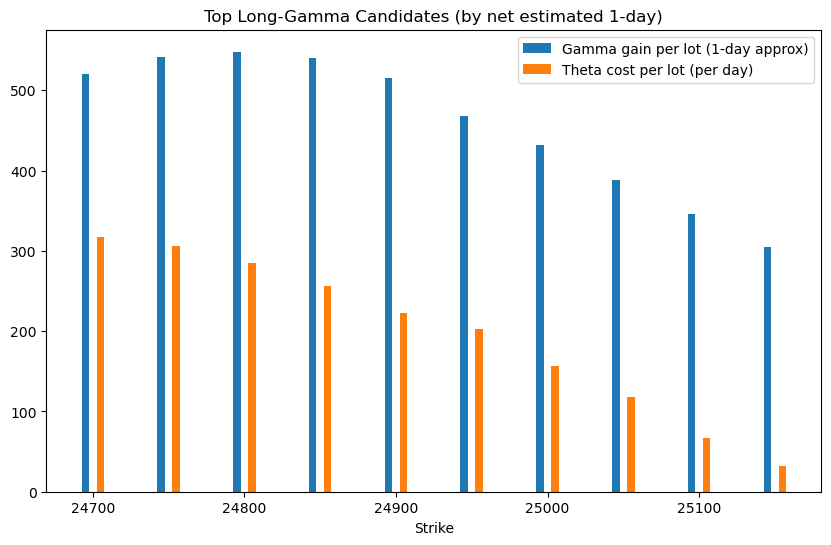

In [24]:
plot_top_candidates(df_greeks, spot)

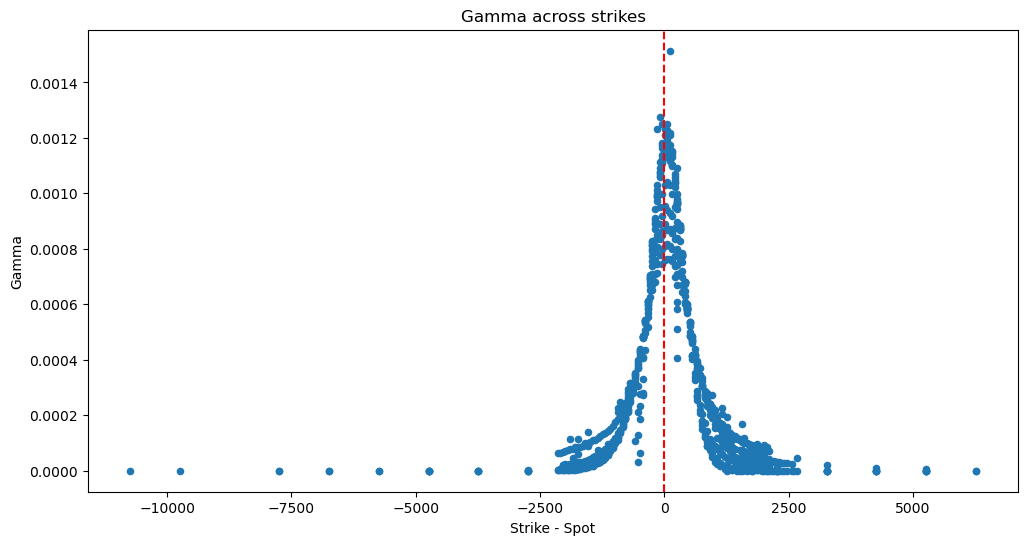

In [25]:
plot_gamma_vs_strike(df_greeks, spot)